In [1]:
from pathlib import Path

import torch
from torch.utils import data
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import NeptuneLogger
import einops

from dataclasses import dataclass
from typing import Iterable, Optional, Union
import xarray as xr
from concurrent import futures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from itertools import chain
import geopandas as gpd

In [2]:
from nowcasting_dataloader.data_sources.satellite.satellite_model import SAT_MEAN, SAT_STD
from nowcasting_dataloader.data_sources.nwp.nwp_model import NWP_MEAN, NWP_STD

# 1. **********
from nowcasting_utils.metrics.validation import make_validation_results
# **********

In [3]:
def save_validation_results_to_logger(
    results_dfs: list[pd.DataFrame],
    results_file_name: str,
    current_epoch: Union[int, str],
    logger: Optional[NeptuneLogger] = None,
):
    # join all validation step results together
    results_df = pd.concat(results_dfs)
    results_df.reset_index(inplace=True)

    # save to csv file
    name_csv = f"{results_file_name}_{current_epoch}.csv"
    results_df.to_csv(name_csv)

    # upload csv to neptune
    logger.experiment[f"validation/results/epoch_{current_epoch}"].upload(name_csv)

In [4]:
def get_pv_system_id_index_lut():
    # In get_gsp_id_and_pv_system_index_for_each_pv_system(), we really don't want to have to loop round each example and each PV system.  
    # So, instead, we create a "look up table" (LUT) where the entry at the i^th index
    # is the index of the PV system (and len(passiv_2_minutely_pv_system_ids) elsewhere)
    # (i.e. len(passiv_2_minutely_pv_system_ids) is used as a marker for "NaN"... it has to be a real int
    # otherwise the Embedding blows up).
    # That is, `lut[pv_system_id]` is the `index+1` of the PV system.
    passiv_2_minutely_pv_system_ids = pd.read_csv("passiv_2_minutely_pv_system_IDs.csv", index_col="index", squeeze=True).to_list()
    missing_pv_maker = len(passiv_2_minutely_pv_system_ids)+1
    pv_system_id_index_lut = np.full(
        shape=max(passiv_2_minutely_pv_system_ids)+1, 
        fill_value=missing_pv_maker, 
        dtype=np.int16
    )
    pv_system_id_index_lut[passiv_2_minutely_pv_system_ids] = np.arange(0, len(passiv_2_minutely_pv_system_ids), dtype=np.int16)
    
    # test
    assert pv_system_id_index_lut[0] == missing_pv_maker  # No PV system pv_system_id 0
    for i in [0, 1, 100, 1000, len(passiv_2_minutely_pv_system_ids)-1]:
        pv_system_id = passiv_2_minutely_pv_system_ids[i]
        assert pv_system_id_index_lut[pv_system_id] == i
    return pv_system_id_index_lut


pv_system_id_index_lut = get_pv_system_id_index_lut()

In [5]:
# Load a mapping from satellite pixel x and y coords to GSP ID
gsp_id_per_satellite_pixel = xr.load_dataset("GSP_ID_per_satellite_pixel.nc")["data"]

In [6]:
# we use the number MAX_GSP_ID to indicate a "missing GSP" to the GSP ID embedding
MAX_GSP_ID = int(np.nanmax(gsp_id_per_satellite_pixel.values) + 1)
gsp_id_per_satellite_pixel = gsp_id_per_satellite_pixel.fillna(MAX_GSP_ID).astype(np.int32)

In [7]:
def get_pv_system_id_to_gsp_lut():
    """Get a look up table (LUT) which maps from PV system ID to GSP ID.
    """
    passiv_pv_system_id_to_gsp_id = pd.read_csv("passiv_pv_system_id_to_gsp_id.csv", index_col="system_id", squeeze=True)
    missing_gsp_marker = MAX_GSP_ID,  # Use max(gsp_id)+1 as the marker for "missing" GSP
    pv_system_id_to_gsp_lut = np.full(
        shape=max(passiv_pv_system_id_to_gsp_id.index)+1, 
        fill_value=missing_gsp_marker,
        dtype=np.int16
    )
    pv_system_id_to_gsp_lut[passiv_pv_system_id_to_gsp_id.index] = passiv_pv_system_id_to_gsp_id
    
    # test
    assert pv_system_id_to_gsp_lut[0] == missing_gsp_marker
    for i in [0, 1, 100, 1000, len(passiv_pv_system_id_to_gsp_id)-1]:
        pv_system_id = passiv_pv_system_id_to_gsp_id.index[i]
        gsp_id = passiv_pv_system_id_to_gsp_id.loc[pv_system_id]
        assert pv_system_id_to_gsp_lut[pv_system_id] == gsp_id

    return pv_system_id_to_gsp_lut


pv_system_id_to_gsp_lut = get_pv_system_id_to_gsp_lut()

In [8]:
def get_gsp_id_and_pv_system_index_for_each_pv_system(pv_system_id_tensor: torch.Tensor) -> tuple[np.ndarray, np.array]:
    """For each PV system ID in batch['pv_system_id'], get the GSP ID and the "index" of the PV system (used for embedding the PV system ID)."""
   
    pv_system_id_tensor = torch.nan_to_num(
        pv_system_id_tensor, 
        nan=0  # No PV systems have the ID "0".  So 0 is safe to use as a marker for "missing".
    ).to(torch.int16)

    pv_system_id_index = pv_system_id_index_lut[pv_system_id_tensor]
    gsp_id_for_each_pv_system = pv_system_id_to_gsp_lut[pv_system_id_tensor]
    return gsp_id_for_each_pv_system, pv_system_id_index

In [9]:
DATA_PATH = Path("/mnt/storage_ssd_4tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/prepared_ML_training_data/v15")

SATELLITE_CHANNELS = (
    "IR_016",
    "IR_039",
    "IR_087",
    "IR_097",
    "IR_108",
    "IR_120",
    "IR_134",
    "VIS006",
    "VIS008",
    "WV_062",
    "WV_073",
)

NWP_CHANNELS = (
    "t",
    "dswrf",
    "prate",
    "r",
    "sde",
    "si10",
    "vis",
    "lcc",
    "mcc",
    "hcc"
)

In [10]:
def satellite_normalisation_stats_to_data_array(stat: dict, channel_names: tuple[str]) -> xr.DataArray:
    return xr.DataArray(
        [stat[chan_name] for chan_name in channel_names],
        dims="channels_index",
    ).astype(np.float32).assign_coords(channels=("channels_index", list(channel_names)))

SAT_MEAN = satellite_normalisation_stats_to_data_array(SAT_MEAN, SATELLITE_CHANNELS)
SAT_STD = satellite_normalisation_stats_to_data_array(SAT_STD, SATELLITE_CHANNELS)
NWP_MEAN = satellite_normalisation_stats_to_data_array(NWP_MEAN, NWP_CHANNELS)
NWP_STD = satellite_normalisation_stats_to_data_array(NWP_STD, NWP_CHANNELS)

In [11]:
def align_time(src: xr.Dataset, dst: xr.Dataset) -> xr.Dataset:
    """Align `dst` to have the same `time` coords as `src.time`.
    
    For example, use this to ensure that batch['opticalflow'] has the same
    time coords as batch['gsp'].
    """
    # I tried a bunch of "vectorised" ways of doing this.  This appears to be the
    # only way of doing it.  The issue is that each example ends up having different
    # time_index coords so, in order to align, we must reset the "time_index" of each example.
    # We take the satellite image _15 minutes_ before the GSP data, because the GSP data is
    # the average power for the half-hour-ending.
    time_index = src.time - pd.Timedelta("15 minutes")
    n_timesteps = src.time.shape[1]
    time_index_bool_mask = dst.time.isin(time_index)
    data_arrays_for_examples = []
    n_examples = len(time_index_bool_mask)
    for example_i in range(n_examples):
        selection = dst.isel(example=example_i, time_index=time_index_bool_mask[example_i])
        # Ensure there are never too many timesteps
        selection = selection.isel(time_index=slice(None, n_timesteps))
        selection.__setitem__("time_index", np.arange(len(selection["time_index"])))
        data_arrays_for_examples.append(selection)
        
    new_dst = xr.concat(data_arrays_for_examples, dim="example")
    return new_dst

In [12]:
N_DATETIME_FEATURES = 4  # sin & cos for time of day and day of year


def create_datetime_features(t0_datetimes: np.ndarray) -> dict[str, np.ndarray]:
    t0_datetimes = pd.DatetimeIndex(t0_datetimes)
    n_examples = len(t0_datetimes)

    datetime_features = np.full(shape=(n_examples, N_DATETIME_FEATURES), fill_value=np.NaN, dtype=np.float32)

    hour_of_day = t0_datetimes.hour + (t0_datetimes.minute / 60)
    day_of_year = t0_datetimes.day_of_year + (hour_of_day / 24)

    hour_of_day_radians = (hour_of_day / 24.0) * 2 * np.pi
    day_of_year_radians = (day_of_year / 366 ) * 2 * np.pi  #  366 for leap years!

    datetime_features[:, 0] = np.sin(hour_of_day_radians)
    datetime_features[:, 1] = np.cos(hour_of_day_radians)
    datetime_features[:, 2] = np.sin(day_of_year_radians)
    datetime_features[:, 3] = np.cos(day_of_year_radians)
    
    return {
        "t0_datetime_features": datetime_features,
        "t0_hour_of_day": hour_of_day.values,
        "t0_day_of_year": day_of_year.values,
        "t0_month": t0_datetimes.month.values,
        "t0_datetime_UNIX_epoch": t0_datetimes.values.astype("datetime64[s]").astype(np.int32),
    }

In [13]:
def copy_x_and_y_and_time_coords(data_from_all_sources: dict[str, object], data_source_name: str):
    data = data_from_all_sources[data_source_name]
    data_from_all_sources[f"{data_source_name}_time"] = torch.from_numpy(data["time"].values.astype("datetime64[s]").astype(np.int32))
    
    if data_source_name in ["satellite", "opticalflow"]:
        # satellite and opticalflow mistakenly include x and y coords for every timestep (even though they don't change across time!)
        x_coords = data["x"].isel(time_index=0)
        y_coords = data["y"].isel(time_index=0)
    elif data_source_name in ["gsp", "pv"]:
        # The x and y coords DataArrays are called "x_coords" and "y_coords" in gsp and pv.  And "x" and "y" in the others.
        x_coords = data["x_coords"]
        y_coords = data["y_coords"]
        if data_source_name == "pv":
            # Set the x_coords, y_coords and time for missing PV systems to NaN
            mask_of_missing_pv_systems = np.isnan(data["data"].values).any(axis=1)
            x_coords.values[mask_of_missing_pv_systems] = np.NaN
            y_coords.values[mask_of_missing_pv_systems] = np.NaN
    else:
        x_coords = data["x"]
        y_coords = data["y"]
        
    data_from_all_sources[f"{data_source_name}_x_coords"] = torch.from_numpy(x_coords.values.astype(np.float32))
    data_from_all_sources[f"{data_source_name}_y_coords"] = torch.from_numpy(y_coords.values.astype(np.float32))

In [14]:
@dataclass
class SimpleNowcastingDataset(data.Dataset):
    """
    Attributes:
        data_path: Base path to the pre-prepared dataset.  e.g. .../v15/train/
        data_source_names: The names of the data sources.  Must also be the names of the subdirectory.  
            Must include "gsp".
        gsp_first_time_index_of_future: The index into the GSP time_index dimension that marks the start of the "future".
        n_batches: The number of available batches.
    """
    data_path: Path
    data_source_names: Iterable[str]
    gsp_first_time_index_of_future: int = 2
    
    def __post_init__(self):
        # Sanity checks
        assert self.data_path.exists()
        assert len(self.data_source_names) > 0
        assert "gsp" in self.data_source_names
        self.n_batches = self._get_number_of_batches()
        
    def _get_number_of_batches(self) -> int:
        """Get number of batches.  Check every data source."""
        n_batches = None
        for data_source_name in self.data_source_names:
            path_for_data_source = self.data_path / data_source_name
            n_batches_for_data_source = len(list(path_for_data_source.glob("*.nc")))
            if n_batches is None:
                n_batches = n_batches_for_data_source
            else:
                assert n_batches == n_batches_for_data_source
        assert n_batches is not None
        assert n_batches > 0
        return n_batches
    
    def __len__(self) -> int:
        return self.n_batches
    
    def __getitem__(self, idx: int):
        """
        Returned shapes:
            gsp: batch_size, n_timesteps
            opticalflow: "example", "time_index", "channels_index",  "y_index", "x_index"
            nwp: "example", "time_index", "channels_index", "y_index", "x_index"
            pv:
        """
        data_from_all_sources = {}
        # Parallelising this with concurrent.futures.ThreadPoolExecutor actually
        # appears to be _slower_ than the simple loop approach!
        for data_source_name in self.data_source_names:
            filename = self.data_path / data_source_name / f"{idx:06d}.nc"
            dataset = xr.open_dataset(filename)
            
            # Select just the "future" timesteps at half-hour intervals (t1, t2, etc.)
            # for the first GSP (the "target").
            if data_source_name == "gsp":
                dataset = dataset.isel(
                    time_index=slice(self.gsp_first_time_index_of_future, None),
                    id_index=0
                ).load()
                # Normalise GSP
                dataset["data"] = dataset["power_mw"] / dataset["capacity_mwp"]
                dataset["data"] = dataset["data"].astype(np.float32)
                
                # Datetime features
                t0_datetimes = dataset.time.values[:, 0] - pd.Timedelta("30 minutes")
                
            if data_source_name == "pv":
                try:
                    dataset = dataset.isel(time_index=slice(None, 7))
                except ValueError as e:
                    print(f"Exception raised when reading PV: {filename}", flush=True)
                    raise
                dataset["data"] = dataset["power_mw"] / dataset["capacity_mwp"]
            
            if data_source_name in ["satellite", "opticalflow"]:
                # Normalise satellite and opticalflow
                dataset["data"] = dataset["data"].astype(np.float32)
                dataset["data"] -= SAT_MEAN.drop("channels")
                dataset["data"] /= SAT_STD.drop("channels")
                dataset["data"] = dataset["data"].transpose("example", "time_index", "channels_index", "y_index", "x_index")
                
            if data_source_name == "nwp":
                # Normalise satellite and opticalflow
                dataset["data"] -= NWP_MEAN.drop("channels")
                dataset["data"] /= NWP_STD.drop("channels")
                dataset["data"] = dataset["data"].transpose("example", "time_index", "channels_index", "y_index", "x_index")

            data_from_all_sources[data_source_name] = dataset

        if ("satellite" in self.data_source_names) and ("opticalflow" in self.data_source_names):
            # Concatenate half an hour of satellite data to the start of the opticalflow data
            # so we can use imagery 15 minutes before the GSP timestep, because the GSP data
            # is half-hour-ending.
            data_from_all_sources["opticalflow"] = xr.concat(
                (
                    data_from_all_sources["satellite"].isel(time_index=slice(None, 7)),
                    data_from_all_sources["opticalflow"]
                ),
                dim="time_index",
            )
            del data_from_all_sources["satellite"]

        # Conform Satellite data sources to have the same time index as GSP
        for data_source_name in ["satellite", "opticalflow", "hrvsatellite", "hrvopticalflow"]:
            if data_source_name in data_from_all_sources:
                data_from_all_sources[data_source_name] = align_time(
                    src=data_from_all_sources["gsp"],
                    dst=data_from_all_sources[data_source_name].load())
                
        # Select just the data.  Grab other useful DataArrays.
        new_data_source_names = list(data_from_all_sources.keys())
        for data_source_name in new_data_source_names:
            try:
                copy_x_and_y_and_time_coords(data_from_all_sources, data_source_name)
            except:
                print("Exception raised while processing", data_source_name)
                raise

            data = data_from_all_sources[data_source_name]

            if data_source_name == "pv":
                data_from_all_sources["pv_system_id"] = torch.from_numpy(data["id"].values.astype(np.float32))
                pv_gsp_id, pv_system_id_index = get_gsp_id_and_pv_system_index_for_each_pv_system(data_from_all_sources["pv_system_id"])
                data_from_all_sources["pv_gsp_id"] = torch.from_numpy(pv_gsp_id)
                data_from_all_sources["pv_system_id_index"] = torch.from_numpy(pv_system_id_index)
                
            if data_source_name == "gsp":
                data_from_all_sources["gsp_id"] = torch.from_numpy(data["id"].values.astype(np.float32))
                data_from_all_sources["capacity_mwp"] = torch.from_numpy(data["capacity_mwp"].values.astype(np.float32))

            data_from_all_sources[data_source_name] = torch.from_numpy(data["data"].values)
            
        # Datetime features.
        t0_datetime_features = create_datetime_features(t0_datetimes)
        for feature_name, feature_values in t0_datetime_features.items():
            data_from_all_sources[feature_name] = torch.from_numpy(feature_values)
        
        # Get GSP ID for each satellite pixel
        gsp_id_per_satellite_pixel_list = []
        for x_coords, y_coords in zip(data_from_all_sources["opticalflow_x_coords"], data_from_all_sources["opticalflow_y_coords"]):      
            selected_data = (
                gsp_id_per_satellite_pixel.sel(
                    x=x_coords,
                    y=y_coords,
                    method="nearest",
                )
            )
            gsp_id_per_satellite_pixel_list.append(selected_data)
        data_from_all_sources["gsp_id_per_satellite_pixel"] = torch.from_numpy(
            np.stack(gsp_id_per_satellite_pixel_list)
        )
        
        # Check for NaNs
        for data_source_name, data in data_from_all_sources.items():
            if data_source_name != "gsp_id" and not data_source_name.startswith("pv") and np.isnan(data).any():
                raise RuntimeError(f"NaNs in {data_source_name} batch {idx}")

        return data_from_all_sources

In [15]:
DATA_SOURCE_NAMES = ("gsp", "satellite", "pv", "opticalflow", "nwp")

In [16]:
train_dataset = SimpleNowcastingDataset(
    data_path=DATA_PATH / "train",
    data_source_names=DATA_SOURCE_NAMES,
)

In [17]:
len(train_dataset)

8400

In [18]:
%%time
batch = train_dataset[1]

CPU times: user 402 ms, sys: 44.1 ms, total: 446 ms
Wall time: 399 ms


In [17]:
def tensor_nanmin(tensor, dim):
    return torch.from_numpy(np.nanmin(tensor.cpu(), axis=dim)).to(device=tensor.device)


def tensor_nanmax(tensor, dim):
    return torch.from_numpy(np.nanmax(tensor.cpu(), axis=dim)).to(device=tensor.device)


def rescale_tensors_to_0_to_1(tensors: dict[str, torch.Tensor]) -> dict[str, torch.Tensor]:
    """Rescales multiple tensors using the same min and max across all tensors.
    
    Args:
        tensors: A dictionary of Tensors.  The dictionary keys should be the name of each tensor.
            The values of dictionary should be Tensors of shape [batch_size, length].  All tensors
            must have the same batch_size.
            
    Returns:
        rescaled_tensors: A dict with the same keys as the input `tensors` dict but where each
            tensor has had its values rescaled to be in the range [0, 1].
    """
   
    # Compute the maximum and the range, across all teh tensors.
    list_of_tensors = list(tensors.values())
    tensors_concatenated = torch.cat(list_of_tensors, dim=1)
    del list_of_tensors
    minimum = tensor_nanmin(tensors_concatenated, dim=1)
    maximum = tensor_nanmax(tensors_concatenated, dim=1)
    min_max_range = maximum - minimum
    del maximum

    minimum = minimum.unsqueeze(-1)
    min_max_range = min_max_range.unsqueeze(-1)
    
    # Rescale each tensor
    rescaled_tensors = {}
    for name, tensor in tensors.items():
        rescaled_tensors[name] = (tensor - minimum) / min_max_range
        
    return rescaled_tensors

In [18]:
def compute_fourier_features(array: torch.Tensor, n_fourier_features: int = 4, min_freq: float = 1, max_freq: float = 4) -> torch.Tensor:
    """Compute fourier features for a single dimension, across all examples in a batch.
    
    Adapted from https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    
    Args:
        array: Tensor of shape [batch_size, length] with values in the range [0, 1].
            For the time dimension, `length` will be the timeseries sequence length.
            For spatial dimensions, `length` will be the width or height.
        n_fourer_features: Total number of requested fourier features
        
    Returns:
        fourer_features: A tensor of the same dtype and device as `array`,
            with shape [batch_size, length, n_fourier_features].  Fourier features with even indexes
            are sine.  Odd indexes are cosine.
    """
    #assert np.nanmax(array) <= 1
    #assert np.nanmin(array) >= 0
    assert n_fourier_features % 2 == 0
    assert min_freq > 0
    assert max_freq > min_freq

    batch_size, length = array.shape[:2]
    array = array * np.pi / 2
    array = array.unsqueeze(-1)
    div_term = torch.linspace(start=min_freq, end=max_freq, steps=n_fourier_features // 2, dtype=array.dtype, device=array.device)
    fourier_features = torch.full(
        size=(batch_size, length, n_fourier_features), 
        fill_value=np.NaN, 
        dtype=array.dtype, 
        device=array.device,
    )

    fourier_features[:, :, 0::2] = torch.sin(array * div_term)
    fourier_features[:, :, 1::2] = torch.cos(array * div_term)
    return fourier_features

In [19]:
def get_spatial_and_temporal_fourier_features(
    batch: dict[str, torch.Tensor], 
    num_fourier_time_features: int = 4,
    num_fourier_spatial_features_total: int = 8,  # Total for both height and width
) -> None:
    for dim_name in ('_x_coords', '_y_coords', 'time'):
        all_coords = {key: tensor for key, tensor in batch.items() if key.endswith(dim_name)}
        if f"gsp{dim_name}" in all_coords and dim_name != "time":
            # We're only selecting a single GSP.  So GSP x_coords and y_coords are 1D.  We want 2D.
            all_coords[f"gsp{dim_name}"] = all_coords[f"gsp{dim_name}"].unsqueeze(-1)
        all_coords = rescale_tensors_to_0_to_1(all_coords)
        if dim_name == "time":
            n_fourier_features = num_fourier_time_features
        else:
            n_fourier_features = num_fourier_spatial_features_total // 2
        for key, coords in all_coords.items():
            batch[f"{key}_fourier_features"] = compute_fourier_features(
                coords,
                n_fourier_features=n_fourier_features,
                min_freq=4,
                max_freq=32,
            )
    

In [21]:
get_spatial_and_temporal_fourier_features(batch)

fig, ax = plt.subplots()
ax.scatter(batch['opticalflow_x_coords'][0], batch['opticalflow_y_coords'][0]);
ax.scatter(batch['pv_x_coords'][0], batch["pv_y_coords"][0], color="green")
ax.scatter(batch['nwp_x_coords'][0], batch['nwp_y_coords'][0]);
ax.scatter(batch['gsp_x_coords'][0], batch["gsp_y_coords"][0], color='red');

NameError: name 'batch' is not defined

NameError: name 'batch' is not defined

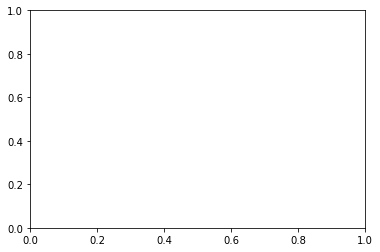

In [22]:
fig, ax = plt.subplots()
ax.plot(batch["t0_datetime_features"], label=['time_of_day_sin', 'time_of_day_cos', 'day_of_year_sin', 'day_of_year_cos'])
ax.legend();

In [24]:
# shape: batch, timestep, pv system
batch["pv"].isnan().shape

torch.Size([32, 7, 128])

In [25]:
batch["pv"].isnan().any(dim=1).shape

torch.Size([32, 128])

128

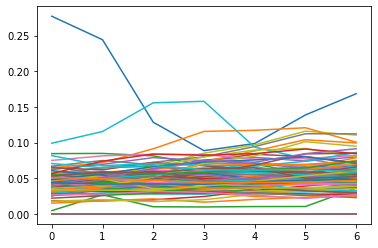

In [26]:
len(plt.plot(batch["pv"][0]))

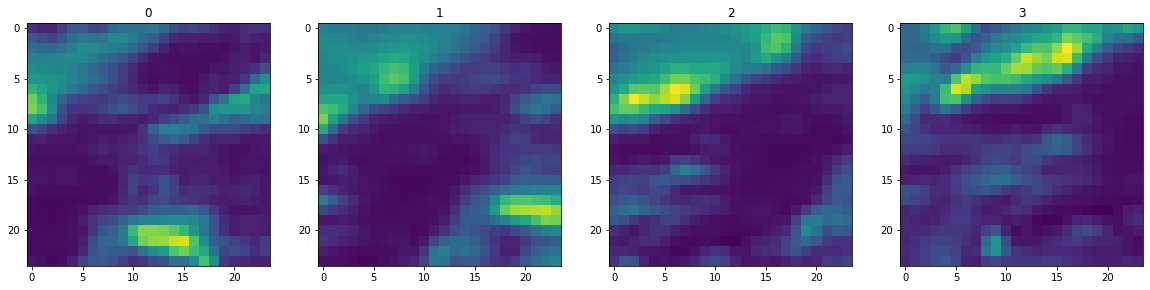

In [27]:
def plot_imagery(tensor, example_i, channel_i):
    fig, axes = plt.subplots(ncols=4, figsize=(20, 10))
    # axes = list(chain.from_iterable(axes))
    # "example", "time_index", "channels_index", "y_index", "x_index"
    data_to_plot = tensor[example_i, :4, channel_i, :, :]
    vmin = data_to_plot.min()
    vmax = data_to_plot.max()
    for time_index, ax in enumerate(axes):
        ax.imshow(data_to_plot[time_index].numpy()[::-1], vmin=vmin, vmax=vmax)
        ax.set_title(time_index)
    return fig, axes

EXAMPLE_I = 1
CHANNEL_I = 7
plot_imagery(batch["opticalflow"], example_i=EXAMPLE_I, channel_i=CHANNEL_I);

## Put the dataset into a DataLoader

In [20]:
dataloader_kwargs = dict(
    batch_size=None,
    num_workers=14,
    pin_memory=True,
)

In [21]:
train_dataloader = data.DataLoader(
    train_dataset,
    **dataloader_kwargs
)

In [22]:
test_dataloader = data.DataLoader(
    SimpleNowcastingDataset(
        data_path=DATA_PATH / "test",
        data_source_names=DATA_SOURCE_NAMES,
    ),
    **dataloader_kwargs
)

In [23]:
%%time
for batch in train_dataloader:
    break

CPU times: user 3.71 s, sys: 2.55 s, total: 6.25 s
Wall time: 11.2 s


# Define the ML model

Each input "row" to the Perceiver will look like this:

Shape: batch_size, seq_len, embedding_dim

Try to keep the constant-length things in the same position.  e.g. the modality embedding always comes first.  The position encoding always comes second (for modalities which have spatial positions).

Plan for Friday:

* Opticalflow: (just one timestep at a time)
    - relative temporal encoding for that timestep of imagery (4)
    - relative x and y position encoding (8)
    - 4x4 patch of pixel values (16)
    - learnt channel embedding (4)
    - learnt modality identifier (8)
* PV: (mean across PV systems)
    - relative temporal encoding of t0 (4)
    - entire historical timeseries for mean across PV systems (7)
    - learnt modality identifier (29)
* NWP (mean across x and y positions):
    - relative temporal encoding of t0 (4)
    - entire timeseries for one channel (4)
    - learnt NWP channel embedding (4)
    - learnt modality identifier (28)
* Datetime:
    - all timesteps for forecast (4) x 9 features
    - learnt modality embedding (4)
* GSP ID:
    - embedding of GSP ID
    - learnt modality identifier
* Query:
    - learnt query


Plan for Monday:

All position encodings should capture whether it's within the GSP region or not.

* PV: (individual PV systems)
    - relative temporal encoding of t0 (4)
    - relative x and y position encoding (8)
    - entire historical timeseries for one PV system (7)
    - learnt PV ID embedding (10)
    - learnt modality identifier (11)

* The learnt "query" to the Perceiver:
    - Embedding of the GSP ID?  Or different learnable params, one for each GSP ID?  Or just a single learnt number?
* GSP ID & area
    - **area** (i.e. how big is it?)
    - embedding of GSP ID
    - learnt modality identifier

In [44]:
# Mixture density network


PI = 'PI'
MU = 'MU'
SIGMA = 'SIGMA'
MEAN = 'MEAN'

class MixtureDensityNetwork(nn.Module):
    def __init__(self, in_features: int, num_gaussians: int = 2):
        super().__init__()
        self.pi = nn.Linear(in_features=in_features, out_features=num_gaussians)
        self.mu = nn.Linear(in_features=in_features, out_features=num_gaussians)
        self.sigma = nn.Linear(in_features=in_features, out_features=num_gaussians)
        
    def forward(self, x: torch.Tensor) -> dict[str, torch.Tensor]:
        pi = self.pi(x)
        pi = F.softmax(pi, dim=-1)
        mu = self.mu(x)
        sigma = self.sigma(x)
        sigma = torch.exp(sigma)
        return {PI: pi, MU: mu, SIGMA: sigma}
    
    
def get_distribution(
    network_output: dict[str, torch.Tensor], 
    example_i: Optional[int] = None
) -> torch.distributions.MixtureSameFamily:

    pi = network_output[PI]
    mu = network_output[MU]
    sigma = network_output[SIGMA]
    
    if example_i is not None:
        pi = pi[example_i]
        mu = mu[example_i]
        sigma = sigma[example_i]

    mixture_distribution = torch.distributions.Categorical(probs=pi)
    component_distribution = torch.distributions.Normal(loc=mu, scale=sigma)
    gaussian_mixture_model = torch.distributions.MixtureSameFamily(mixture_distribution, component_distribution)
    return gaussian_mixture_model



def plot_probs(pi, mu, sigma, ax, left, right, example_i=0):
    sweep_n_steps = 100
    sweep_start = 1
    sweep_stop = 0
       
    n_timesteps = pi.shape[1]

    # Define a 'sweep' matrix which we pass into log_prob to get probabilities 
    # for a range of values at each timestep.  Those values range from sweep_start to sweep_stop
    sweep = torch.linspace(start=sweep_start, end=sweep_stop, steps=sweep_n_steps, dtype=torch.float32, device=pi.device)
    sweep = sweep.unsqueeze(-1).expand(sweep_n_steps, n_timesteps)
    
    # Get probabilities.
    distribution = get_distribution({PI: pi, MU: mu, SIGMA: sigma}, example_i=example_i)
    log_probs = distribution.log_prob(sweep)
    probs = torch.exp(log_probs).detach().cpu().numpy()
    
    # Plot!
    extent = (left, right, sweep_stop, sweep_start) # left, right, bottom, top
    ax.imshow(probs, aspect='auto', interpolation='none', extent=extent, cmap='Greys')

    return ax

In [45]:
def plot_timeseries(batch: dict[str, torch.Tensor], network_output: dict[str, torch.Tensor]) -> plt.Figure:
    actual = batch["gsp"].detach().cpu()
    
    # get the mean prediction
    mu = network_output[MU]
    pi = network_output[PI]
    predicted = torch.sum((mu * pi), dim=-1).squeeze().detach().cpu()

    gsp_id = batch["gsp_id"].squeeze().detach().cpu()
    historical_pv = batch["pv"].squeeze().detach().cpu().numpy()
    if "nwp" in batch:
        nwp_chan = NWP_CHANNELS.index("dswrf")
        nwp = batch["nwp"][:, :, nwp_chan].mean(dim=[2, 3]).detach().cpu().numpy()
        nwp_time = batch["nwp_time"].squeeze().detach().cpu().numpy()
    t0_datetimes = batch["t0_datetime_UNIX_epoch"].squeeze().detach().cpu().numpy()
    t0_datetimes = pd.to_datetime(t0_datetimes, unit='s')
    fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20, 20))
    axes = list(chain.from_iterable(axes))
    FIFTEEN_MINUTES = (15 / (60 * 24))
    for example_i, ax in enumerate(axes):
        t0_datetime = t0_datetimes[example_i]
        t1_datetime = t0_datetime + pd.Timedelta("30 minutes")
        forecast_datetimes = pd.date_range(t1_datetime, periods=4, freq="30 min")

        # Plot historical PV yield
        historical_pv_datetimes = pd.date_range(t0_datetime - pd.Timedelta("30 minutes"), periods=7, freq="5 min")
        plot_probs(
            pi=network_output[PI],
            mu=network_output[MU],
            sigma=network_output[SIGMA],
            ax=ax,
            left=mdates.date2num(forecast_datetimes[0]) - FIFTEEN_MINUTES,
            right=mdates.date2num(forecast_datetimes[-1]) + FIFTEEN_MINUTES,
            example_i=example_i,
        )
        ax.plot(
            historical_pv_datetimes,
            historical_pv[example_i],
            color="grey",
            alpha=0.5
        )
        ax.plot(
            historical_pv_datetimes,
            np.nanmean(historical_pv, axis=2)[example_i],
            label="Historical mean PV",
            linewidth=3,
            alpha=0.8,
            color="red",
        )
        
        # Plot prediction for GSP PV yield and actual GSP PV yield
        ax.plot(forecast_datetimes, predicted[example_i], label="Predicted GSP PV", color="orange", linewidth=3, alpha=0.8)
        ax.plot(forecast_datetimes, actual[example_i], label="Actual GSP PV", linewidth=3, alpha=0.8)
        
        # Plot NWP params:
        if "nwp" in batch:
            ax2 = ax.twinx()
            nwp_time_for_example = pd.to_datetime(nwp_time[example_i], unit="s")
            ax2.plot(nwp_time_for_example, nwp[example_i], label="NWP irradiance", color="green", alpha=0.8)
            ax2.yaxis.set_ticks([])
            ax2.set_ylim(-2, 2)
        
        # Formatting
        ax.xaxis.set_major_locator(mdates.HourLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        ax.set_title("GSP {:.0f} on {}".format(gsp_id[example_i], t0_datetime.strftime("%Y-%m-%d")), y=0.8)
        ax.set_ylim(0, 1)
        ax.set_xlim(mdates.date2num(historical_pv_datetimes[0]), mdates.date2num(forecast_datetimes[-1]))
        if example_i == 0:
            fig.legend(framealpha=0, loc="center right")

    return fig

In [46]:

SATELLITE_IMAGE_SIZE_PIXELS = 24

class Model(pl.LightningModule):
    
    # 2. **********
    # list of results dataframes. This is used to save validation results
    results_dfs = []
    # **********
    
    def __init__(
        self, 
        embed_dim_query: int = 128,  # TODO: Play with these numbers
        num_elements_query: int = 32,
        num_heads: int = 16,
        num_latent_transformer_encoder_layers: int = 4,
        dropout: float = 0.0,
        byte_array_dim: int = 64,  # The dimensionality of each key & value element.
        gsp_id_embedding_dim: int = 16,
        num_fourier_time_features: int = 4,
        num_fourier_spatial_features: int = 8,  # Total for both height and width
        satellite_patch_size_per_dim: int = 2,  # The total patch size will be satellite_patch_size_per_dim x satellite_patch_size_per_dim
        satellite_channel_embedding_dim: int = 4,  # The size of the embedding of the satellite channel ID
        nwp_channel_embedding_dim: int = 4,
        share_weights_across_latent_transformer_layers: bool = True,
        pv_system_id_embedding_dim: int = 16,
        results_file_name: str = "results.csv",
        num_gaussians: int = 2,
    ):
        super().__init__()
        self.embed_dim_query = embed_dim_query
        self.num_elements_query = num_elements_query
        self.num_fourier_time_features = num_fourier_time_features
        self.num_fourier_spatial_features = num_fourier_spatial_features
        self.satellite_patch_size_per_dim = satellite_patch_size_per_dim
        self.results_file_name = results_file_name
        self.gsp_id_embedding_dim = gsp_id_embedding_dim
        self.num_gaussians = num_gaussians

        #self.query_norm1 = nn.LayerNorm(embed_dim_query)
        #self.query_norm2 = nn.LayerNorm(embed_dim_query)
        #self.byte_array_norm = nn.LayerNorm(byte_array_dim)
        
        # PERCEIVER #################################
        # Layers for the Perceiver model:
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=embed_dim_query,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
            kdim=byte_array_dim,
            vdim=byte_array_dim
        )
        
        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim_query,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )

        if share_weights_across_latent_transformer_layers:
            self.latent_transformer = nn.Sequential(
                *[transformer_encoder_layer for _ in range (num_latent_transformer_encoder_layers)]
            )
        else:
            self.latent_transformer = nn.TransformerEncoder(
                encoder_layer=transformer_encoder_layer,
                num_layers=num_latent_transformer_encoder_layers,
            )

        # Feed forwards output layers #################################
        self.output_layers = nn.Sequential(
            nn.Linear(in_features=num_elements_query * embed_dim_query, out_features=embed_dim_query),
            nn.ReLU(),
            nn.Linear(in_features=embed_dim_query, out_features=128),
        )
        
        self.mixture_density_network = MixtureDensityNetwork(
            in_features=128,
            num_gaussians=num_gaussians,
        )
        
        self.gsp_id_embedding = nn.Embedding(
            num_embeddings=MAX_GSP_ID + 1,
            embedding_dim=gsp_id_embedding_dim,
        )
        
        self.gsp_id_embedding_query_generator = nn.Sequential(
            nn.Linear(in_features=gsp_id_embedding_dim, out_features=gsp_id_embedding_dim * 2),
            nn.ReLU(),
            nn.Linear(in_features=gsp_id_embedding_dim * 2, out_features=gsp_id_embedding_dim * 2),
            nn.ReLU(),
            nn.Linear(in_features=gsp_id_embedding_dim * 2, out_features=gsp_id_embedding_dim),
            nn.ReLU(),
        )
        
        self.time_fourier_features_query_generator = nn.Sequential(
            nn.Linear(in_features=num_fourier_time_features, out_features=num_fourier_time_features * 2),
            nn.ReLU(),
            nn.Linear(in_features=num_fourier_time_features * 2, out_features=num_fourier_time_features * 2),
            nn.ReLU(),
            nn.Linear(in_features=num_fourier_time_features * 2, out_features=num_fourier_time_features),
            nn.ReLU(),
        )
        
        self.gsp_id_embedding_key_generator = nn.Sequential(
            nn.Linear(in_features=gsp_id_embedding_dim, out_features=gsp_id_embedding_dim * 2),
            nn.ReLU(),
            nn.Linear(in_features=gsp_id_embedding_dim * 2, out_features=gsp_id_embedding_dim * 2),
            nn.ReLU(),
            nn.Linear(in_features=gsp_id_embedding_dim * 2, out_features=gsp_id_embedding_dim),
            nn.ReLU(),
        )
        
        self.satellite_chan_embedding = nn.Embedding(
            num_embeddings=len(SATELLITE_CHANNELS),
            embedding_dim=satellite_channel_embedding_dim,
        )
        self.nwp_chan_embedding = nn.Embedding(
            num_embeddings=len(NWP_CHANNELS),
            embedding_dim=nwp_channel_embedding_dim,
        )
        self.pv_system_id_embedding = nn.Embedding(
            num_embeddings=max(pv_system_id_index_lut) + 1,
            embedding_dim=pv_system_id_embedding_dim,
        )
        
        # Learnable parametrs
        self.register_buffer(
            "query", 
            nn.Parameter(
                torch.randn(
                    num_elements_query, 
                    embed_dim_query
                    - gsp_id_embedding_dim
                    - num_fourier_time_features
                )
            )
        )
        self.register_buffer(
            "learnt_modality_identifier_for_optical_flow", 
            # 36 = 4x4 patch +  + 4 channel embedding
            nn.Parameter(
                torch.randn(
                    byte_array_dim 
                    - num_fourier_time_features
                    - num_fourier_spatial_features
                    - gsp_id_embedding_dim # 16
                    - (satellite_patch_size_per_dim ** 2) 
                    - satellite_channel_embedding_dim
                )
            )
        )
        self.register_buffer(
            "learnt_modality_identifier_for_pv_yield",
            # 7 timesteps of PV data
            nn.Parameter(
                torch.randn(
                    byte_array_dim   # 64
                    - num_fourier_time_features # 4
                    - num_fourier_spatial_features # 8
                    - gsp_id_embedding_dim # 16
                    - pv_system_id_embedding_dim # 16
                    - 7
                )
            )
        )
        self.register_buffer(
            "learnt_modality_identifier_for_nwp",
            # 4 timesteps of NWP data
            nn.Parameter(torch.randn(byte_array_dim - num_fourier_time_features - 4 - nwp_channel_embedding_dim))
        )
        self.register_buffer(
            "learnt_modality_identifier_for_t0_datetime_features", 
            nn.Parameter(torch.randn(byte_array_dim - N_DATETIME_FEATURES))
        )
        self.register_buffer(
            "learnt_modality_identifier_for_gsp_id", 
            nn.Parameter(torch.randn(byte_array_dim - gsp_id_embedding_dim))
        )


        #self.query_generator = nn.Sequential(
        #    nn.Linear(in_features=16, out_features=16),
        #    nn.ReLU(),
        #    nn.Linear(in_features=16, out_features=16),
        #    nn.ReLU(),
        #    nn.Linear(in_features=16, out_features=num_elements_query * embed_dim_query),
        #    nn.ReLU(),
        #)
        
    def forward(self, batch: dict[str, torch.Tensor]) -> torch.Tensor:
        """
        Args:
            batch: Contains these keys:
                - opticalflow: Shape: batch_size, time, "channels_index", "y_index", "x_index"
                
        Returns:
            Tensor of shape batch_size, time
        """
        # byte_arrays is the list of modalities to be concatenated and fed into the perceiver
        byte_arrays: list[torch.Tensor] = []

        #######################################################
        # GENERATE POSITION ENCODING
        get_spatial_and_temporal_fourier_features(
            batch, 
            num_fourier_time_features=self.num_fourier_time_features,
            num_fourier_spatial_features_total=self.num_fourier_spatial_features,  # Total for both height and width
        )
        # batch now has keys like "pv_x_coords_fourier_features"
        
        #######################################################
        # GET DATA INTO THE RIGHT SHAPE #######################
        # satellite data starts with shape "example", "time_index", "channels_index", "y_index", "x_index"
        if "opticalflow" in batch:
            opticalflow = batch["opticalflow"]
            original_batch_size, original_satellite_seq_len = opticalflow.shape[:2]

            # Reshape so each timestep is seen as a separate example
            opticalflow = einops.rearrange(opticalflow, "b t c h w -> (b t) c h w")

            # Take patches of pixels:
            # Adapted from https://github.com/openclimatefix/satflow/blob/main/satflow/models/utils.py#L54
            opticalflow = einops.rearrange(
                opticalflow, 
                "b c (h dh) (w dw) -> b c h w (dh dw)", 
                dh=self.satellite_patch_size_per_dim, 
                dw=self.satellite_patch_size_per_dim,
            )

            b, c, h, w, d = opticalflow.shape
            
            # Do the same for the temporal & spatial encoding
            
            # Reshape so each timestep is seen as a separate example
            batch["opticalflow_time_fourier_features"] = einops.rearrange(
                batch["opticalflow_time_fourier_features"], 
                "b t n_fourier_features -> (b t) n_fourier_features",
            )
            
            # Take patches of pixels:
            for dim_name in ("x_coords", "y_coords"):
                key_name = f"opticalflow_{dim_name}_fourier_features"
                
                batch[key_name] = einops.reduce(
                    batch[key_name], 
                    "b (length dl) n_fourier_features -> b length n_fourier_features",
                    reduction="mean",
                    dl=self.satellite_patch_size_per_dim,
                )
                
                # Repeat
                batch[key_name] = torch.repeat_interleave(batch[key_name], repeats=original_satellite_seq_len, dim=0)
                
            # GSP ID per pixel
            gsp_id_per_pixel = batch["gsp_id_per_satellite_pixel"]
            middle_index = (self.satellite_patch_size_per_dim**2 // 2) + (self.satellite_patch_size_per_dim // 2)
            if middle_index > 0:
                middle_index -= 1
            gsp_id_per_pixel = einops.rearrange(
                gsp_id_per_pixel,
                "b (h dh) (w dw) -> b h w (dh dw)",
                dh=self.satellite_patch_size_per_dim, 
                dw=self.satellite_patch_size_per_dim,
            )[..., middle_index]
            gsp_id_per_pixel = self.gsp_id_embedding_key_generator(self.gsp_id_embedding(gsp_id_per_pixel))
            gsp_id_per_pixel = torch.repeat_interleave(gsp_id_per_pixel, repeats=original_satellite_seq_len, dim=0)

            # Encode the channel
            sat_chan_list = torch.arange(c, device=self.device)
            embedded_sat_chan_list = self.satellite_chan_embedding(sat_chan_list)    

            # Concat position encoding for the height and width:
            opticalflow = torch.cat(
                (
                    einops.repeat(batch["opticalflow_time_fourier_features"], "b n_fourier_features -> b c h w n_fourier_features", b=b, c=c, h=h, w=w),
                    # Position encode the height:
                    # ("d" is the dimensionality of the Perceiver model)
                    # Position encode the width:
                    einops.repeat(batch["opticalflow_x_coords_fourier_features"], "b w d -> b c h w d", b=b, c=c, h=h),
                    einops.repeat(batch["opticalflow_y_coords_fourier_features"], "b h d -> b c h w d", b=b, c=c, w=w),
                    einops.repeat(
                        gsp_id_per_pixel,
                        "b h w d-> b c h w d", b=b, c=c, h=h, w=w,
                    ),
                    opticalflow,
                    einops.repeat(embedded_sat_chan_list, "c d -> b c h w d", b=b, c=c, h=h, w=w),
                    einops.repeat(self.learnt_modality_identifier_for_optical_flow, "d -> b c h w d", b=b, c=c, h=h, w=w),
                ),
                dim=-1,
            )

            # opticalflow now has shape: b, c, h, w, perceiver element dim
            # e.g. 128, 10, 6, 6, 32

            # Reshape into batch_size, perceiver element, perceiver element dim, ready for the perceiver
            opticalflow = einops.rearrange(opticalflow, "b c h w d -> b (c h w) d")
            byte_arrays.append(opticalflow)
        
        #######################################################
        # CROSS ATTENTION! ####################################
        
        # Create query
        # num_elements is the number of elements in the set that's fed into cross attention
        # Embed the GSP ID 
        ##query = self.gsp_id_embedding(batch["gsp_id"])
        # Then put the embedding through a linear layer so the model can learn different queries
        # for each element of the Transformer's input.
        ##query = self.query_generator(query)
        # Repeat for each timestep:
        ##query = torch.repeat_interleave(query, repeats=original_satellite_seq_len, dim=0)
        ##query = query.squeeze()
        ##query = einops.repeat(
        ##    query, 
        ##    "b (num_elements embed_dim) -> b num_elements embed_dim", 
        ##    b=b, 
        ##    num_elements=self.num_elements_query,
        ##    embed_dim=self.embed_dim_query,
        ##)
        
        # GSP ID embedding
        # TODO: Reduce reduncancy between this and datetime features.
        #gsp_embedding = self.gsp_id_embedding(batch["gsp_id"])
        #gsp_embedding = torch.cat(
        #    (
        #        gsp_embedding,
        #        einops.repeat(
        #            self.learnt_modality_identifier_for_gsp_id,
        #            "d -> original_batch_size d",
        #            original_batch_size=original_batch_size,
        #        ),
        #    ), 
        #    dim=-1,
        #)
        #gsp_embedding = torch.repeat_interleave(gsp_embedding, repeats=original_satellite_seq_len, dim=0)
        #byte_arrays.append(gsp_embedding.unsqueeze(1))
        
        # Datetime features
        #t0_datetime_features = torch.cat(
        #    (
        #        batch["t0_datetime_features"],
        #        einops.repeat(
        #            self.learnt_modality_identifier_for_t0_datetime_features,
        #            "d -> original_batch_size d",
        #            original_batch_size=original_batch_size,
        #        ),
        #    ),
        #    dim=-1,
        #)
        #t0_datetime_features = torch.repeat_interleave(t0_datetime_features, repeats=original_satellite_seq_len, dim=0)
        #byte_arrays.append(t0_datetime_features.unsqueeze(1))

        # Historical PV data
        # input shape: batch=32, timestep=7, pv system=128
        # output shape: batch=128, n_pv_systems, d_model
        key_padding_mask = None
        if "pv" in batch:
            pv_yield = batch["pv"]
            pv_yield = einops.rearrange(pv_yield, "b t pv_system -> b pv_system t")
            n_pv_systems = pv_yield.shape[1]
            #RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 1 but got size 128 for tensor number 1 in the list.
            pv_yield = torch.cat(
                (
                    # fourier_time_features["pv_time"] is a tensor of shape [batch_size, seq_length, n_fourier_features]
                    einops.repeat(
                        batch["pv_time_fourier_features"][:, -2:-1],  # Just take the t0 timestep
                        "b 1 d -> b n_pv_systems d",
                        n_pv_systems=n_pv_systems,
                    ),
                    batch["pv_x_coords_fourier_features"],
                    batch["pv_y_coords_fourier_features"],
                    self.gsp_id_embedding_key_generator(
                        self.gsp_id_embedding(batch["pv_gsp_id"].to(torch.int32)),
                    ),
                    pv_yield,
                    # Convert pv_system_id to ints for embedding
                    self.pv_system_id_embedding(
                        batch["pv_system_id_index"].to(torch.int32),
                    ),
                    einops.repeat(
                        self.learnt_modality_identifier_for_pv_yield,
                        "d -> original_batch_size n_pv_systems d",
                        original_batch_size=original_batch_size,
                        n_pv_systems=n_pv_systems,
                    ),
                ),
                dim=-1,
            )
            # We will mask missing PV systems later
            pv_yield = pv_yield.float()
            pv_yield = torch.nan_to_num(pv_yield, nan=-1)
            pv_yield = torch.repeat_interleave(pv_yield, repeats=original_satellite_seq_len, dim=0)
            key_padding_mask = torch.repeat_interleave(batch["pv"].isnan().any(dim=1), repeats=original_satellite_seq_len, dim=0)
            byte_arrays.insert(0, pv_yield)
        
        # NWP data
        # Original shape: "example", "time_index", "channels_index", "y_index", "x_index"
        # We want to end up with each element being all timesteps for a single channel, taking the mean across x and y:
        if "nwp" in batch:
            nwp = batch["nwp"].mean(dim=[-2, -1])  # take the mean across x and y
            nwp = einops.rearrange(nwp, "b t c -> b c t")
            nwp_b, nwp_c, nwp_t = nwp.shape
            # Encode the channel
            nwp_chan_list = torch.arange(nwp_c, device=self.device)
            embedded_nwp_chan_list = self.nwp_chan_embedding(nwp_chan_list)
            embedded_nwp_chan_list = einops.repeat(
                embedded_nwp_chan_list, 
                "c d -> b c d", b=nwp_b, c=nwp_c)
            # RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 1 but got size 10 for tensor number 1 in the list.
            nwp = torch.cat(
                (
                    # fourier_time_features["nwp_time"] is a tensor of shape [batch_size, seq_length, n_fourier_features]
                    einops.repeat(
                        batch["nwp_time_fourier_features"][:, -2:-1],  # Just take the last timestep
                        "b 1 d -> b c d",
                        c=nwp_c,
                    ),
                    nwp,
                    embedded_nwp_chan_list,
                    einops.repeat(
                        self.learnt_modality_identifier_for_nwp,
                        "d -> original_batch_size c d",
                        original_batch_size=original_batch_size,
                        c=nwp_c,
                    ),
                ),
                dim=-1,
            )
            nwp = torch.repeat_interleave(nwp, repeats=original_satellite_seq_len, dim=0)
            byte_arrays.append(nwp)

        # Final preparation of data for Perceiver
        # Shape of data going into perciever: [batch_size, perceiver element, perceiver element dim]
        #         # RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 64 but got size 49 for tensor number 1 in the list.
        byte_array = torch.cat(byte_arrays, dim=1)
        
        if key_padding_mask is not None and key_padding_mask.shape[1] < byte_array.shape[1]:
            # If PV is present, then PV is always the first set of 128 elements (in the 2nd dim).
            # We need to extend the key_padding_mask so it has the same number of elements as byte_array:
            key_padding_mask = torch.cat(
                (
                    key_padding_mask,
                    torch.full(
                        size=(
                            byte_array.shape[0], 
                            byte_array.shape[1] - key_padding_mask.shape[1]
                        ), 
                        fill_value=False, dtype=torch.bool, device=byte_array.device),
                ),
                dim=1
            )

        # Query
        query = einops.repeat(
            self.query, 
            "num_elements embed_dim -> b num_elements embed_dim", 
            b=b, 
            num_elements=self.num_elements_query,
        )
        # Append the GSP ID and forecast_datetime
        query = torch.cat(
            (
                query,
                # The opticalflow time is the time that we want the forecast for.
                einops.repeat(
                    self.time_fourier_features_query_generator(
                        batch["opticalflow_time_fourier_features"],
                    ),
                    "b d -> b num_elements d",
                    b=b,
                    num_elements=self.num_elements_query,
                    d=self.num_fourier_time_features
                ),
                einops.repeat(
                    torch.repeat_interleave(
                        self.gsp_id_embedding_query_generator(
                            self.gsp_id_embedding(
                                    torch.nan_to_num(
                                        batch["gsp_id"],
                                        nan=MAX_GSP_ID,
                                    ).to(torch.int32)
                                ),
                        ),
                        repeats=original_satellite_seq_len,
                        dim=0,
                    ),
                    "b d -> b num_elements d",
                    b=b,
                    num_elements=self.num_elements_query,
                    d=self.gsp_id_embedding_dim
                ),
            ),
            dim=-1
        )
        
        #query = self.query_norm1(query)
        #byte_array = self.byte_array_norm(byte_array)
        
        attn_output, attn_weights = self.cross_attention(query, key=byte_array, value=byte_array, need_weights=False, key_padding_mask=key_padding_mask)
        del attn_weights  # Not used yet.
        
        # LATENT TRANSFORMER
        #attn_output = attn_output + query
        #attn_output = self.query_norm2(attn_output)
        attn_output = self.latent_transformer(attn_output)
        
        # LINEAR LAYERS
        out = self.output_layers(einops.rearrange(attn_output, "b s d -> b (s d)"))
        out = self.mixture_density_network(out)
        
        # Reshape back to b, t, 1
        return {
            key: einops.rearrange(
                tensor,
                "(b t) num_gaussians -> b t num_gaussians", 
                b=original_batch_size, 
                t=original_satellite_seq_len,
                num_gaussians=self.num_gaussians,
            )
            for key, tensor in out.items()
        }
    
    def _training_or_validation_step(self, batch: dict[str, torch.Tensor], batch_idx: int, tag: str) -> dict[str, object]:
        """
        Args:
            batch: The training or validation batch.  A dictionary.
            tag: Either "train" or "validation"
            batch_idx: The index of the batch.
        """
        actual_gsp_power = batch["gsp"]
        network_output = self(batch)
        distribution = get_distribution(network_output)
        neg_log_prob_loss = torch.mean(-distribution.log_prob(actual_gsp_power))
        
        # get the mean prediction
        mu = network_output[MU]
        pi = network_output[PI]
        predicted_gsp_power = torch.sum((mu * pi), dim=-1)
        
        mse_loss = F.mse_loss(predicted_gsp_power, actual_gsp_power)
        nmae_loss = F.l1_loss(predicted_gsp_power, actual_gsp_power)
        
        self.log_dict(
            {
                f"negative_log_probability/{tag}": neg_log_prob_loss,
                f"MSE/{tag}": mse_loss,
                f"NMAE/{tag}": nmae_loss,
            },
            on_step=True,
            on_epoch=True,
            sync_dist=True,  # Required for distributed training (even multi-GPU on signle machine)
        )

        if batch_idx < 3:
            # Log timeseries of actual GSP power and predicted GSP power
            figure_name = f"{tag}/plot/timeseries/epoch={self.current_epoch};batch_idx={batch_idx}"
            fig = plot_timeseries(batch=batch, network_output=network_output)
            self.logger.experiment[figure_name].log(fig)
            plt.close(fig)
            
        # Get NMAE per GSP, per forecast timestep, per day of year, and per hour of day
        abs_error = (predicted_gsp_power - actual_gsp_power).abs().squeeze().cpu().detach()
        nmae_per_example = abs_error.mean(dim=1)
        metrics = {
            "loss": neg_log_prob_loss,
            "NMAE": nmae_loss.detach(),
            "NMAE_per_example": nmae_per_example,
            "NMAE_per_forecast_timestep": pd.Series(abs_error.mean(dim=0), index=np.arange(1, 5), name=batch_idx, dtype=np.float32),
        }
        for key in ("gsp_id", "t0_hour_of_day", "t0_month"):
            metrics[f"NMAE_per_{key}"] = pd.Series(
                nmae_per_example, 
                index=batch[key].cpu().numpy().astype(np.int32), 
                name=batch_idx,
                dtype=np.float32
            ).groupby(level=0).mean()
            
            
        # 3. ************ 
        # save validation results
        capacity = batch["capacity_mwp"].cpu().numpy()
        predictions = predicted_gsp_power.detach().cpu().numpy().squeeze()
        truths = actual_gsp_power.detach().cpu().numpy().squeeze()
        predictions = predictions * capacity
        truths = truths * capacity

        results = make_validation_results(
            truths_mw=truths,
            predictions_mw=predictions,
            capacity_mwp=capacity,
            gsp_ids=batch["gsp_id"].cpu(),
            batch_idx=batch_idx,
            t0_datetimes_utc=pd.to_datetime(
                batch["t0_datetime_UNIX_epoch"].cpu().numpy().squeeze(), 
                unit="s"
            )
        )
        
        # append so in 'validation_epoch_end' the file is saved
        if batch_idx == 0:
            self.results_dfs = []
        self.results_dfs.append(results)
        
        # ***************

        return metrics
    
    def _training_or_validation_epoch_end(self, step_outputs: list[dict], tag: str) -> None:
        # step_outputs is a list of dicts.  We want a dict of lists :)
        metric_names = step_outputs[0].keys()
        dict_of_lists_of_metrics: dict[str, list] = {metric_name: [] for metric_name in metric_names}
        for step_output in step_outputs:
            for metric_name, metric_value in step_output.items():
                dict_of_lists_of_metrics[metric_name].append(metric_value)

        # Loop through the metrics we're interested in
        metrics_we_want = set(metric_names) - set(["loss", "NMAE", "NMAE_per_example"])
        for metric_name in metrics_we_want:
            metric_df = pd.concat(dict_of_lists_of_metrics[metric_name], axis="columns")
            mean_metric = metric_df.mean(axis="columns")
            if metric_name == "NMAE_per_gsp_id":
                mean_metric = mean_metric.sort_values()
            else: 
                mean_metric = mean_metric.sort_index()
            # Plot!
            fig, ax = plt.subplots(figsize=(40, 20))
            mean_metric.plot.bar(ax=ax)
            figure_name = f"{tag}/plot/{metric_name}/epoch={self.current_epoch}"
            ax.set_ylabel("NMAE")
            ax.set_title(figure_name)
            self.logger.experiment[figure_name].log(fig)
            plt.close(fig)
            
        # Histogram of NMAE across all examples
        nmae_per_example = np.concatenate(dict_of_lists_of_metrics["NMAE_per_example"])
        if not np.isnan(nmae_per_example).any():
            fig, ax = plt.subplots(figsize=(20, 20))
            ax.hist(nmae_per_example, bins=64)
            ax.set_title("Histogram of NMAE across all examples")
            ax.set_ylabel("count")
            ax.set_xlabel("NMAE")
            self.logger.experiment[f"{tag}/plot/hist_of_NMAE_per_example/epoch={self.current_epoch}"].log(fig)
            plt.close(fig)
            
        # 4. *********
        
        
        save_validation_results_to_logger(results_dfs=self.results_dfs,
                                          results_file_name=self.results_file_name + tag,
                                          current_epoch=self.current_epoch,
                                          logger=self.logger)
        
        # ********

    def training_step(self, batch: dict[str, torch.Tensor], batch_idx: int):
        return self._training_or_validation_step(batch=batch, batch_idx=batch_idx, tag="train")
    
    def validation_step(self, batch: dict[str, torch.Tensor], batch_idx: int):
        return self._training_or_validation_step(batch=batch, batch_idx=batch_idx, tag="validation")
    
    def training_epoch_end(self, training_step_outputs):
        self._training_or_validation_epoch_end(training_step_outputs, tag="train")
        
    def validation_epoch_end(self, validation_step_outputs):
        self._training_or_validation_epoch_end(validation_step_outputs, tag="validation")
        
    # 4. *********
    def test_epoch_end(self, test_step_outputs):
        save_validation_results_to_logger(results_dfs=self.results_dfs,
                                          results_file_name=self.results_file_name + "test",
                                          current_epoch=self.current_epoch,
                                          logger=self.logger)
        
    def test_step(self, batch, batch_idx):
        self.validation_step(batch=batch, batch_idx=batch_idx)
        
    # ********

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer

In [47]:
#model = Model()
model = Model.load_from_checkpoint("/home/jack/dev/ocf/predict_pv_yield/notebooks/.neptune/Untitled/PRED-735/checkpoints/epoch=3-step=33599.ckpt")

In [39]:
model.device

device(type='cpu')

In [40]:
#list(model.parameters())

In [41]:
prediction = model(batch)

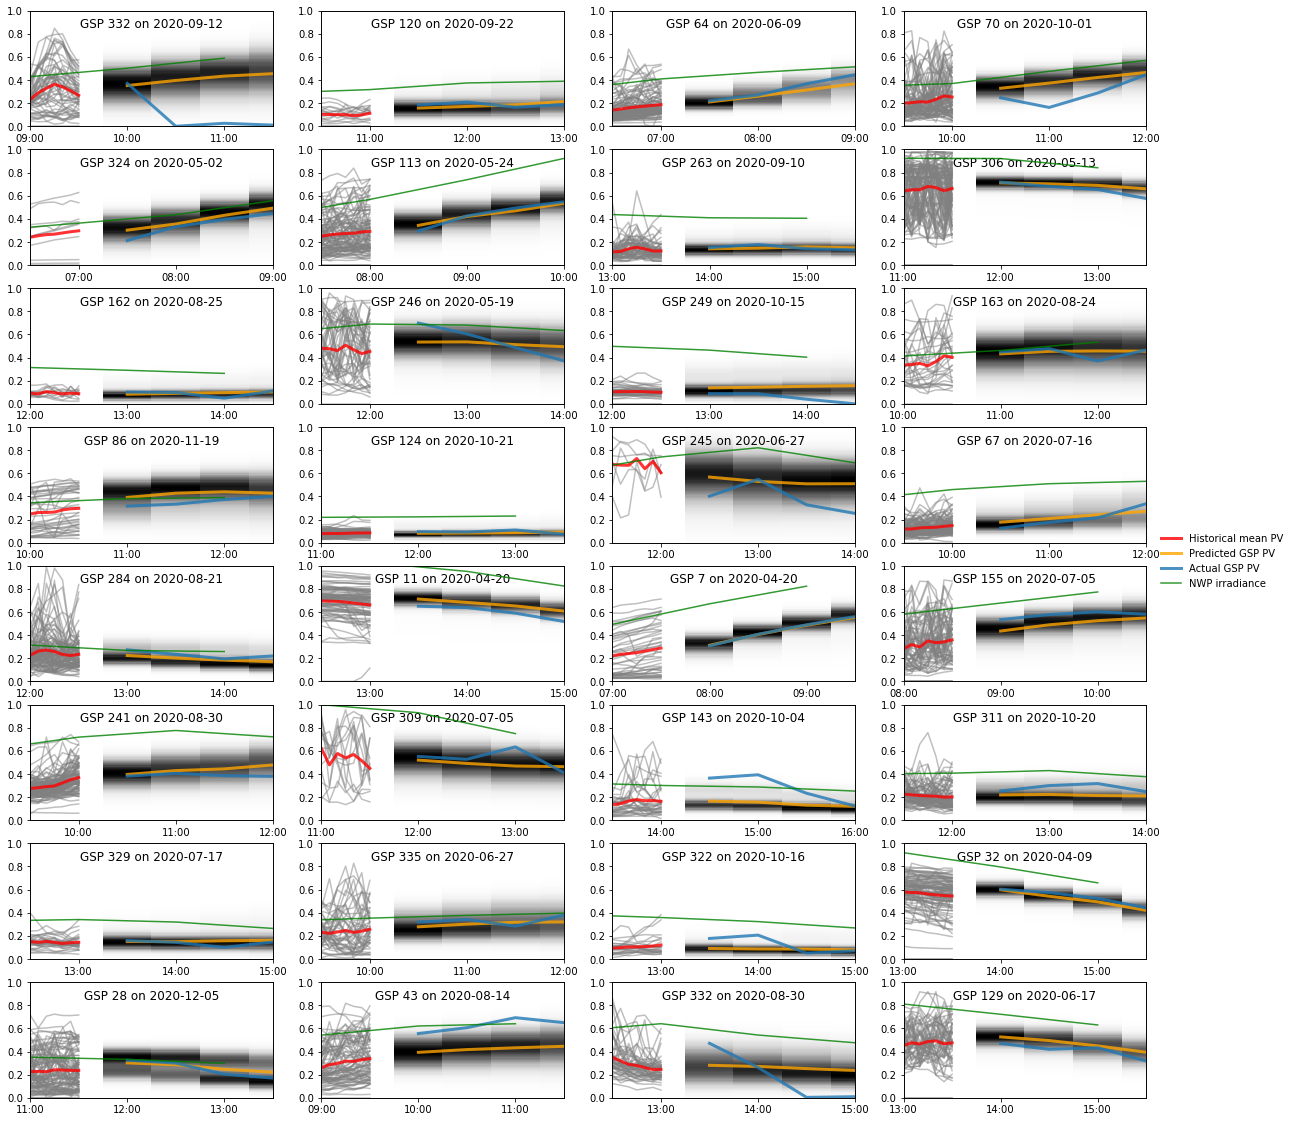

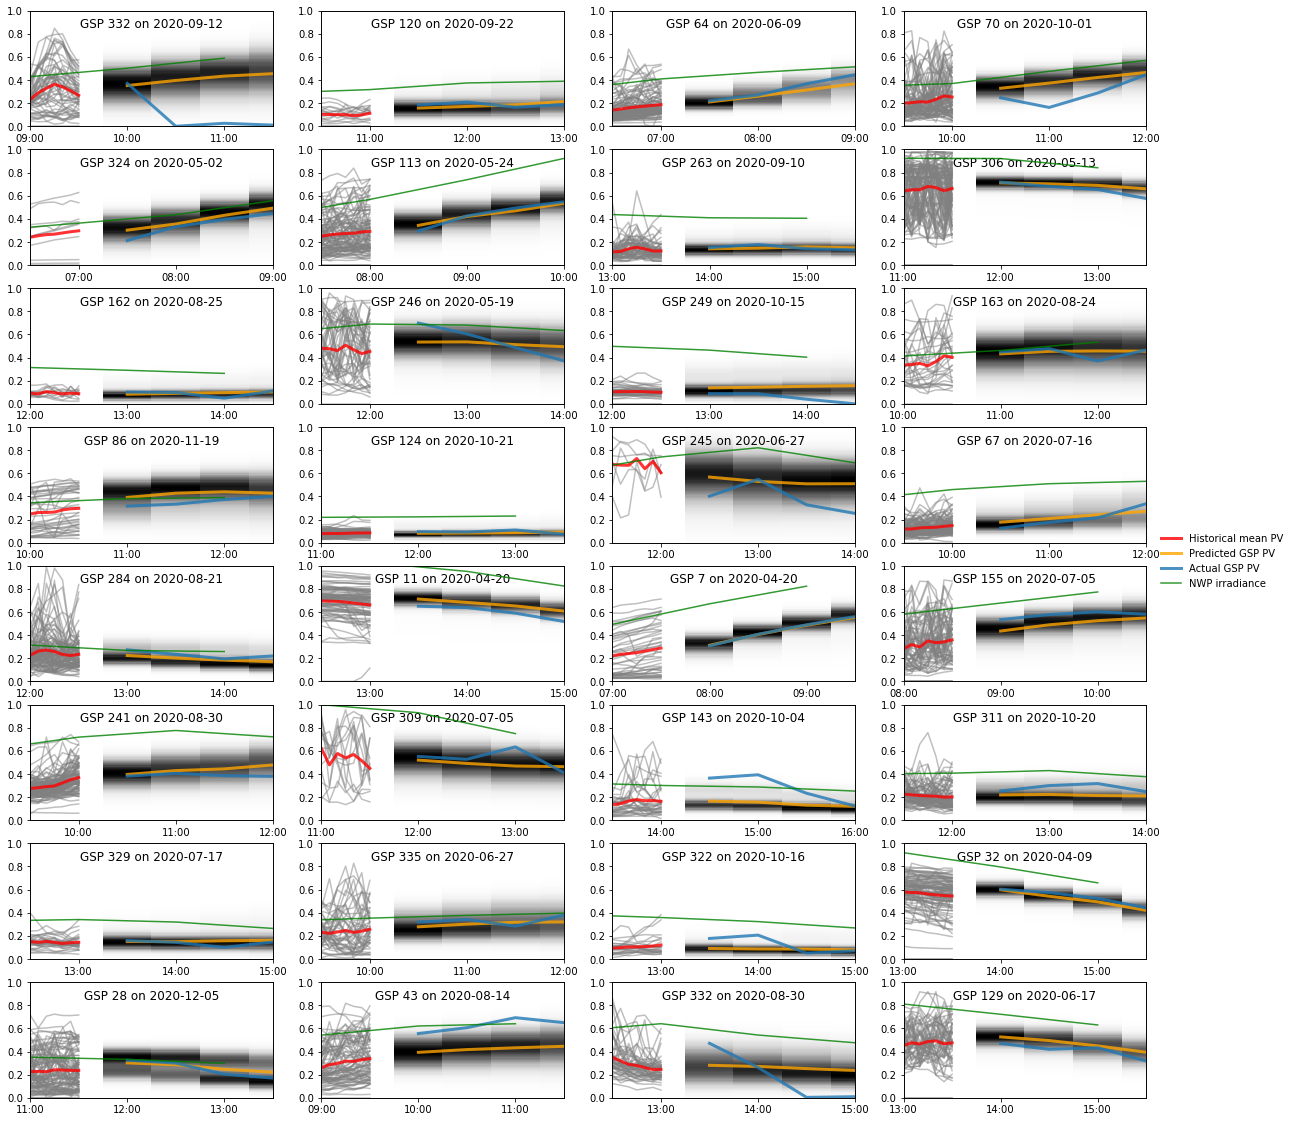

In [42]:
plot_timeseries(batch, prediction)

In [32]:
neptune_logger = NeptuneLogger(
    project="OpenClimateFix/predict-pv-yield",
    prefix=""
)

https://app.neptune.ai/OpenClimateFix/predict-pv-yield/e/PRED-742
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [33]:
trainer = pl.Trainer(gpus=[1], logger=neptune_logger)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, train_dataloader, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

   | Name                                  | Type                  | Params
---------------------------------------------------------------------------------
0  | cross_attention                       | MultiheadAttention    | 49.7 K
1  | latent_transformer                    | Sequential            | 593 K 
2  | output_layers                         | Sequential            | 540 K 
3  | mixture_density_network               | MixtureDensityNetwork | 774   
4  | gsp_id_embedding                      | Embedding             | 5.4 K 
5  | gsp_id_embedding_query_generator      | Sequential            | 2.1 K 
6  | time_fourier_features_query_generator | Sequential            | 148   
7  | gsp_id_embedding_key_generator        | Sequential            | 2.1 K 
8  | satellite_chan_embedding              | Embedding             | 44    
9  | nwp_chan_embedding                    | Embedding             | 40    
10 | pv_system_id_embedding        

Epoch 0:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 8401/8800 [13:59<00:39, 10.00it/s, loss=-1.25, v_num=-742]
Validating: 0it [00:00, ?it/s]
Epoch 1:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 8401/8800 [15:07<00:43,  9.26it/s, loss=-1.27, v_num=-742]
Validating: 0it [00:00, ?it/s]
Epoch 2:   0%|                                                                                                                                                                    | 1/8800 [00:14<34:13:36, 14.00s/it, loss=-1.25, v_num=-742]

In [ ]:
long_test_dataloader = data.DataLoader(
    SimpleNowcastingDataset(
        data_path=Path("/mnt/storage_ssd_4tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/prepared_ML_training_data/v16/test/"),
        data_source_names=DATA_SOURCE_NAMES,
    ),
    **dataloader_kwargs
)

In [28]:
%%time
trainer.test(
    model, 
    long_test_dataloader, 
    ckpt_path="/home/jack/dev/ocf/predict_pv_yield/notebooks/.neptune/Untitled/PRED-693/checkpoints/epoch=43-step=369599.ckpt"
)

Restoring states from the checkpoint path at /home/jack/dev/ocf/predict_pv_yield/notebooks/.neptune/Untitled/PRED-693/checkpoints/epoch=43-step=369599.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
Loaded model weights from checkpoint at /home/jack/dev/ocf/predict_pv_yield/notebooks/.neptune/Untitled/PRED-693/checkpoints/epoch=43-step=369599.ckpt


Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10131/10131 [16:55<00:00,  9.82it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'MSE/validation': 0.008235395886003971,
 'MSE/validation_epoch': 0.008235395886003971,
 'NMAE/validation': 0.06460548937320709,
 'NMAE/validation_epoch': 0.06460548937320709}
--------------------------------------------------------------------------------
Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10131/10131 [17:06<00:00,  9.87it/s]
CPU times: user 11min 28s, sys: 2min 9s, total: 13min 38s
Wall time: 17min 6s


[{'MSE/validation': 0.008235395886003971,
  'MSE/validation_epoch': 0.008235395886003971,
  'NMAE/validation': 0.06460548937320709,
  'NMAE/validation_epoch': 0.06460548937320709}]